# Activity Satisfaction Predictor

## Import dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.naive_bayes import GaussianNB

## Store data in a pd.DataFrame() and perform basic operations

In [3]:
df_orig = pd.read_csv('activity-satisfaction-form.csv')

In [4]:
column_names = ['Timestamp', 'Name', 'Activity', 'Date', 'Time', 
                'Weekday', 'Social context', 'Location', 'Duration',
                'Cost', 'Mental effort', 'Physical effort', 'Creativity level',
                'Focus level', 'Autonomy', 'Social inter qlt', 'Productivity', 
                'Enjoyment', 'Fulfillment', 'Satisfaction'
                ]

df_orig.columns = column_names
df = df_orig.copy()

In [5]:
df.head()

,Timestamp,Name,Activity,Date,Time,Weekday,Social context,Location,Duration,Cost,Mental effort,Physical effort,Creativity level,Focus level,Autonomy,Social inter qlt,Productivity,Enjoyment,Fulfillment,Satisfaction
0,2025/10/30 11:34:03 AM GMT,NaN,Gym workout,2025-10-30,10:00,Thursday,Alone,Gym,60,£5,3,9,NaN,4.0,Self-initiated,NaN,7.0,7,9,8
1,2025/10/30 9:29:58 PM GMT,Mikhail,Making math notes,2025-10-30,12:00,Thursday,Alone,Home,120,0,7,1,3.0,7.0,Self-initiated,NaN,6.0,3,8,5
2,2025/10/30 10:05:23 PM GMT,Mikhail,Reading machine learning book,2025-10-30,16:00,Thursday,Alone,Home,45,0,9,1,4.0,8.0,Self-initiated,NaN,9.0,7,9,9
3,2025/10/30 10:07:29 PM GMT,Mikhail,Playing a video games,2025-10-30,18:00,Thursday,Alone,Home,60,0,2,1,4.0,4.0,Self-initiated,NaN,NaN,9,3,6
4,2025/10/30 10:11:51 PM GMT,Mikhail,Picking up girlfriend after work,2025-10-30,19:30,Thursday,Partner,Outdoors,60,0,2,5,NaN,NaN,Self-initiated,8.0,NaN,10,10,10


Notice the target variables *Enjoyment*, *Fulfillment*, and *Satisfaction*:

- The minimum values for the three columns are 3, 2, and 4, which is quite high;

- The median is at 7.5, 8.5, and 8, which is a strong indicator the data lacks examples on the lower end;

- Keep in mind: it may be beneficial to collect more examples with lower 
target variable values for a rich variety of predictions

In [6]:
df.describe()

,Mental effort,Physical effort,Creativity level,Focus level,Social inter qlt,Productivity,Enjoyment,Fulfillment,Satisfaction
count,30.000000,30.000000,13.000000,15.000000,19.000000,15.000000,30.000000,30.000000,30.000000
mean,3.733333,3.000000,3.538462,6.400000,6.315789,6.800000,7.433333,7.633333,7.700000
std,2.517981,2.212815,1.613246,1.956674,2.029029,1.320173,2.430884,2.235811,1.985291
min,1.000000,1.000000,1.000000,3.000000,2.000000,5.000000,3.000000,2.000000,4.000000
25%,2.000000,1.000000,3.000000,5.000000,4.500000,6.000000,6.250000,7.000000,6.000000
50%,2.500000,2.500000,4.000000,7.000000,7.000000,7.000000,7.500000,8.500000,8.000000
75%,5.500000,4.000000,4.000000,7.500000,8.000000,7.500000,9.750000,9.000000,9.000000
max,9.000000,9.000000,6.000000,10.000000,9.000000,9.000000,10.000000,10.000000,10.000000


[]

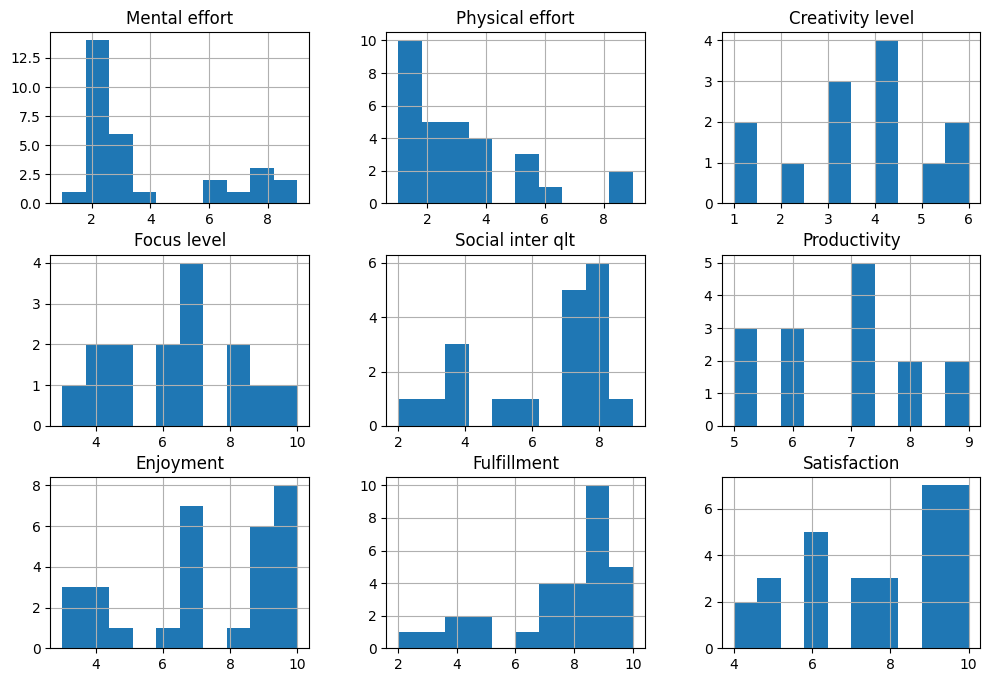

In [11]:
df.hist(bins=10, figsize=(12, 8))
plt.plot()

## Data preprocessing tasks:

- Replace NaN values in *Name, Creativity level, Focus level, Social inter qlt, Productivity*

- Encode (*Date*) and *Time* cyclically

- Encode categorical features

- Perform feature scaling / standardisation on numerical features

In [141]:
# ignore Timestamp and Date features
df = df.drop(['Timestamp', 'Date'], axis=1, errors='ignore')

Here we can see the features that contain missing values,
which we will need to deal with during the preprocessing stage

In [142]:
cols_with_na = df.columns[df.isna().any()].tolist()
df[cols_with_na].head()

,Name,Creativity level,Focus level,Social inter qlt,Productivity
0,NaN,NaN,4.0,NaN,7.0
1,Mikhail,3.0,7.0,NaN,6.0
2,Mikhail,4.0,8.0,NaN,9.0
3,Mikhail,4.0,4.0,NaN,NaN
4,Mikhail,NaN,NaN,8.0,NaN


In [143]:
df.iloc[0, 0] = 'Mikhail'
df.loc[df['Name'] == 'Andrey M', 'Name'] = 'Andrey'
df = df.drop('Name', axis=1, errors='ignore')
cols_with_na.remove('Name')
cols_with_na

['Creativity level', 'Focus level', 'Social inter qlt', 'Productivity']

In [144]:
for col in cols_with_na:
    df[col] = df[col].fillna(df[col].median())
df[cols_with_na].head()

,Creativity level,Focus level,Social inter qlt,Productivity
0,4.0,4.0,7.0,7.0
1,3.0,7.0,7.0,6.0
2,4.0,8.0,7.0,9.0
3,4.0,4.0,7.0,7.0
4,4.0,7.0,8.0,7.0


In [145]:
def encode_cyclical_data(df):
    hours = df['Time'].str.slice(0, 2, 1).astype(int)
    mins = df['Time'].str.slice(3, 5, 1).astype(int)

    hours_sin = np.sin(2*np.pi*(hours / 24))
    hours_cos = np.cos(2*np.pi*(hours / 24))
    mins_sin = np.sin(2*np.pi*(mins / 60))
    mins_cos = np.cos(2*np.pi*(mins / 60))

    df['Hours Sin'] = hours_sin
    df['Hours Cos'] = hours_cos
    df['Mins Sin'] = mins_sin
    df['Mins Cos'] = mins_cos

    return df.drop('Time', axis=1, errors='ignore')

In [146]:
df = encode_cyclical_data(df)

In [147]:
replace_dur = [i for i in df['Duration'].values if not i.isdigit()]
non_num_dur = [i.replace(',', '.') for i in replace_dur]
mins_dur = []
for val in non_num_dur:
    mins_dur.append(float(''.join([char for char in val if char.isdigit() or char == '.']))*60)
df = df.replace(dict(zip(replace_dur, mins_dur)))

In [148]:
replace_cost = [i for i in df['Cost'].values if not i.isdigit()]
pounds_cost = [i[1:] if i[0] == '£' else i for i in replace_cost]
pounds_cost
def euro_to_pound(euro):
    return euro*0.88

pounds_cost[1] = euro_to_pound(float(pounds_cost[1]))
pounds_cost[2] = euro_to_pound(float(pounds_cost[2][:2]))

pounds_cost = [float(i) for i in pounds_cost]

df = df.replace(dict(zip(replace_cost, pounds_cost)))

In [149]:
df.head()

,Activity,Weekday,Social context,Location,Duration,Cost,Mental effort,Physical effort,Creativity level,Focus level,Autonomy,Social inter qlt,Productivity,Enjoyment,Fulfillment,Satisfaction,Hours Sin,Hours Cos,Mins Sin,Mins Cos
0,Gym workout,Thursday,Alone,Gym,60,5.0,3,9,4.0,4.0,Self-initiated,7.0,7.0,7,9,8,5.000000e-01,-8.660254e-01,0.000000e+00,1.0
1,Making math notes,Thursday,Alone,Home,120,0,7,1,3.0,7.0,Self-initiated,7.0,6.0,3,8,5,1.224647e-16,-1.000000e+00,0.000000e+00,1.0
2,Reading machine learning book,Thursday,Alone,Home,45,0,9,1,4.0,8.0,Self-initiated,7.0,9.0,7,9,9,-8.660254e-01,-5.000000e-01,0.000000e+00,1.0
3,Playing a video games,Thursday,Alone,Home,60,0,2,1,4.0,4.0,Self-initiated,7.0,7.0,9,3,6,-1.000000e+00,-1.836970e-16,0.000000e+00,1.0
4,Picking up girlfriend after work,Thursday,Partner,Outdoors,60,0,2,5,4.0,7.0,Self-initiated,8.0,7.0,10,10,10,-9.659258e-01,2.588190e-01,1.224647e-16,-1.0


In [150]:
# use a pipeline for one-hot-encoding and feature scaling
categorical_cols = ['Activity', 'Weekday', 'Social context', 'Location', 'Autonomy']
categorical_transformer = Pipeline(steps=[
    ('one-hot-encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_cols = ['Duration', 'Cost', 'Mental effort', 'Physical effort', 'Creativity level', 'Focus level', 'Social inter qlt', 'Productivity']
numerical_transformer = Pipeline(steps=[
    ('scale-feature', StandardScaler())
])

In [151]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ]
)

In [152]:
features = categorical_cols + numerical_cols + ["Hours Sin", "Hours Cos", "Mins Sin", "Mins Cos"]

In [153]:
# X_df = df[features]
# y_df = df['Satisfaction']
# X = X_df.to_numpy()
# y = y_df.to_numpy()
X = df[features]
y = df['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=104, 
                                                    test_size=0.25, 
                                                    shuffle=True)

In [154]:
alphas = np.logspace(-3, 3, num=100)

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('naive_bayes', GaussianNB())
])

In [156]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('one-hot-encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Activity', 'Weekday',
                                                   'Social context', 'Location',
                                                   'Autonomy']),
                                                 ('num',
                                                  Pipeline(steps=[('scale-feature',
                                                                   StandardScaler())]),
                                                  ['Duration', 'Cost',
                                                   'Mental effort',
                                                   'Physical effort',
                                                   'Creativity level',
                                                   'Focus level',
                                                   'Social inter qlt',
                                                   'Productivity'])])),
                ('regressor', GaussianNB())])

In [158]:
y_pred = pipeline.predict(X_train)
for i in range(len(X_train)):
    print(f'Prediction: {y_pred[i]} --- Real value: {y_train.values[i]}')

Prediction: 6 --- Real value: 6
Prediction: 7 --- Real value: 7
Prediction: 10 --- Real value: 10
Prediction: 9 --- Real value: 9
Prediction: 9 --- Real value: 9
Prediction: 10 --- Real value: 10
Prediction: 6 --- Real value: 6
Prediction: 7 --- Real value: 7
Prediction: 8 --- Real value: 8
Prediction: 8 --- Real value: 8
Prediction: 8 --- Real value: 8
Prediction: 9 --- Real value: 9
Prediction: 6 --- Real value: 6
Prediction: 5 --- Real value: 5
Prediction: 10 --- Real value: 10
Prediction: 10 --- Real value: 10
Prediction: 5 --- Real value: 5
Prediction: 9 --- Real value: 9
Prediction: 4 --- Real value: 4
Prediction: 4 --- Real value: 4
Prediction: 5 --- Real value: 5
Prediction: 6 --- Real value: 6
